<h1><center>Bike Sharing Assignment</center></h1>

**Business Objective:** The company BoomBikes wants to understand and predict the demand for shared bikes among people. As a part of this, the business objective is modelling the demand for shared bikes with the available variables collected by the service provider across the American market.

**Evaluation Metric**: The Evaluation metric is R2 Score

## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from pandas.api.types import  is_object_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
pd.set_option("display.max_columns", 500)

## Loading the Data

In [2]:
df = pd.read_csv("data/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Initial Data Checks

In [3]:
print(f"Shape of data: {df.shape}")

Shape of data: (730, 16)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
print("Checking for presence of infinite values in data")
df[(df.eq(np.inf))|(df.eq(-np.inf))].any()

Checking for presence of infinite values in data


instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [6]:
print("Check for present of duplicate date values (more than 1 record for a particular day)")
df.groupby("dteday",).count().gt(1).all()

Check for present of duplicate date values (more than 1 record for a particular day)


instant       False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

## Inference
1. Data contains 730 records and 16 columns
2. Data doesn't contain any null or infinite values.
3. Data is present at day-level granularity
4. Each day contains only one record.

#### Issues

- The column 'instant' is an index column and doesn't bear any significane, so it can be dropped
- season, yr, month, holiday,weekday,workingday, weathersit identified as float, the correct datatype should be object dtype
- casual + registered = cnt (response variable), so either drop casual and registered or transform the variables into a single column
    - Using both these features may give great results, but in real life inference, we won't be having these features while predicting the total users (else we can just add the two, no ML model required in this case)
- date column identified as object, need to convert to suitable format

### Data Cleaning

In [7]:
"""
1. Drop Index column
2. Convert the above date related columns to object datatype
3. Transform casual and registered columns( + drop the two columns)
4. Convert 'dteday' column to datetime format
"""

# df['registered/casual ratio'] = df['registered']/df['casual']
df = df.drop(columns = ['casual', 'registered', 'instant'])
df['dteday'] = pd.to_datetime(df['dteday'], format = "%d-%m-%Y")
df['weekday'] = df['dteday'].dt.dayofweek
df['weekday'] = df['weekday'].map({0: 'Mon',
                                  1: 'Tue', 
                                  2: 'Wed',
                                  3: 'Thru',
                                  4: 'Fri',
                                  5: 'Sat',
                                  6: 'Sun'})
df['weathersit'] = df['weathersit'].map({ 1:' Clear, Few clouds',
                                        2: 'Mist + Cloudy',
                                        3: 'Light Snow, Light Rain', 
                                        4:' Heavy Rain + Ice Pallets'})

df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
# for column in ['yr', 'mnth', 'holiday']:
df['mnth'] = df['mnth'].astype(str)


for column in ['yr', 'holiday', 'workingday']:
    df[column] = df[column].astype('uint8')

In [8]:
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,spring,0,1,0,Mon,0,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,2018-01-02,spring,0,1,0,Tue,0,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,2018-01-03,spring,0,1,0,Wed,1,"Clear, Few clouds",8.050924,9.47025,43.7273,16.636703,1349
3,2018-01-04,spring,0,1,0,Thru,1,"Clear, Few clouds",8.200000,10.60610,59.0435,10.739832,1562
4,2018-01-05,spring,0,1,0,Fri,1,"Clear, Few clouds",9.305237,11.46350,43.6957,12.522300,1600


In [9]:
df.dtypes

dteday        datetime64[ns]
season                object
yr                     uint8
mnth                  object
holiday                uint8
weekday               object
workingday             uint8
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

### Checking For Unique Values in Categorical Columns

In [10]:
for column in ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']:
    print({column: df[column].unique()})

{'season': array(['spring', 'summer', 'fall', 'winter'], dtype=object)}
{'yr': array([0, 1], dtype=uint8)}
{'mnth': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)}
{'holiday': array([0, 1], dtype=uint8)}
{'weekday': array(['Mon', 'Tue', 'Wed', 'Thru', 'Fri', 'Sat', 'Sun'], dtype=object)}
{'workingday': array([0, 1], dtype=uint8)}
{'weathersit': array(['Mist + Cloudy', ' Clear, Few clouds', 'Light Snow, Light Rain'],
      dtype=object)}


### Correlation Clustermap for Continuous Variables

<Figure size 2160x2160 with 0 Axes>

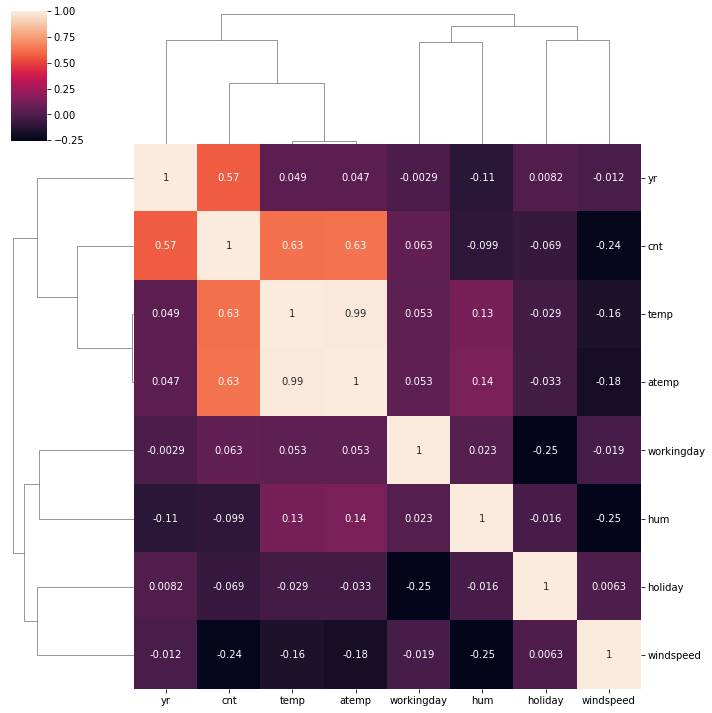

In [11]:
plt.figure(figsize = (30, 30))
sns.clustermap(df.corr(),annot = True)
plt.show()

### Inference

- temp and atemp columns have very high correlation, as they essentially convey the same information. However, 'atemp' or the 'feels like' temperature is what usually an individual experiences. Hence, we can drop the 'temp' column, however, we will create an additional column 'atemp/temp' which carries the effect of how much the temperature feels like compared to the actual temperature

In [12]:
# df['atemp/temp ratio'] = df['atemp']/df['temp']

df.drop(columns = ['temp'], inplace = True)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,2018-01-01,spring,0,1,0,Mon,0,Mist + Cloudy,18.18125,80.5833,10.749882,985
1,2018-01-02,spring,0,1,0,Tue,0,Mist + Cloudy,17.68695,69.6087,16.652113,801
2,2018-01-03,spring,0,1,0,Wed,1,"Clear, Few clouds",9.47025,43.7273,16.636703,1349
3,2018-01-04,spring,0,1,0,Thru,1,"Clear, Few clouds",10.60610,59.0435,10.739832,1562
4,2018-01-05,spring,0,1,0,Fri,1,"Clear, Few clouds",11.46350,43.6957,12.522300,1600


## Data Analysis and Preprocessing

### Pairplot Analysis

- Understanding the comparative scatterplot relation between all numeric columns in one plot

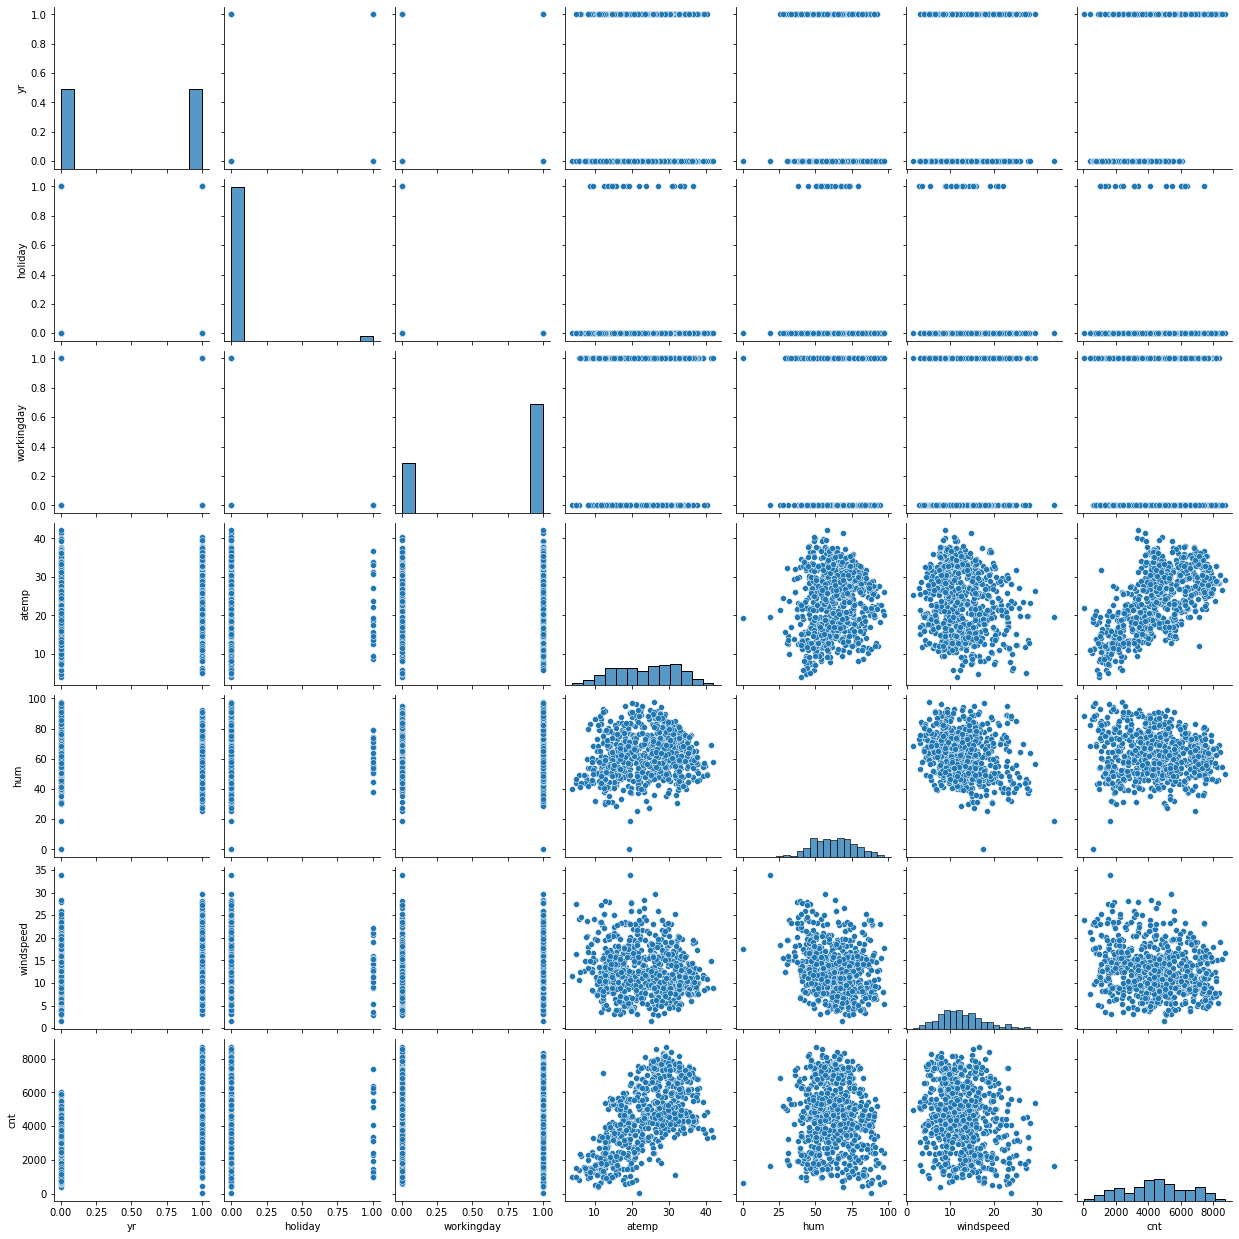

In [13]:
sns.pairplot(df)
plt.show()

### Inference

- 'atemp' has a moderately strong linear relationship with the target variable 'cnt'
- other features like windspeed, humidity seem to be uncorrelated with the target variable


## Data Visualisations

#### 1. Visualising Categorical Variables with the target variable

- Pieplots for univariate
- Segmented Distribution Plots and Time Series Plots for Segmented Univariate

In [14]:
def create_categorical_plots(data, column):
    """
    Function for plotting side by side pie chart
    and barplot for a particular categorical variable
    in the given dataframe
    
    :args:
    
    data -> pandas.DataFrame
    column -> Categorical column : str
    """
    fig, ax = plt.subplots(1,2, figsize = (25, 6),)
    fig.suptitle(f"Categorical Plots: {column}", fontsize = 16,)
    
    data_grouped = data.groupby(column, as_index = False).size()
    list_pie_vals = [0]* data_grouped.shape[0]
    list_pie_vals[np.argmax(data_grouped['size'].tolist())] = 0.1
    ax[0].pie(labels = data_grouped[column].tolist(), x= data_grouped['size'].tolist(), autopct='%.0f%%', explode = list_pie_vals)
    ax[0].set_title(f"Pie Chart: {column}")
    sns.barplot(data = data_grouped, x = column, y = 'size', ax = ax[1])   
    ax[1].set_title(f"Barplot: {column}")
    ax[1].grid()
    ax[1].tick_params(rotation = 45)

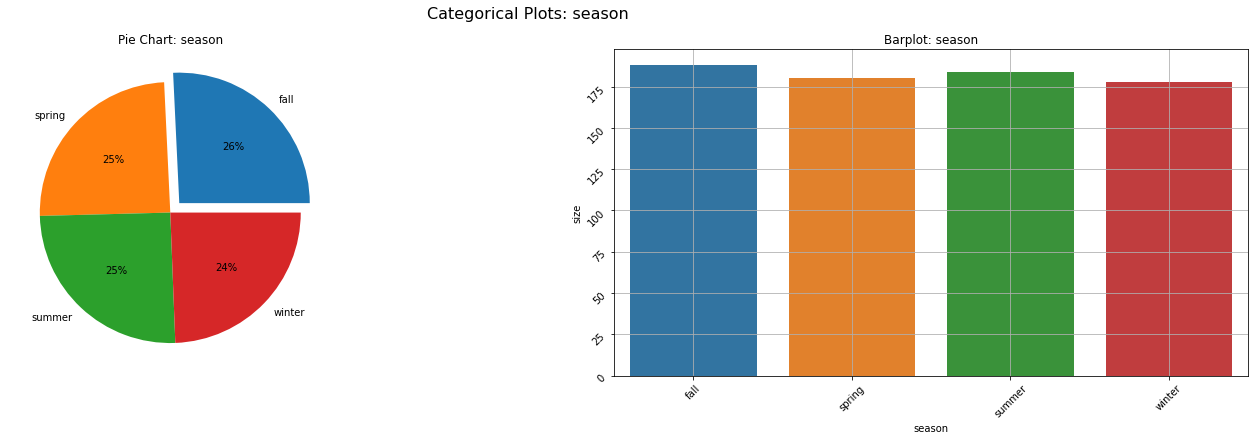

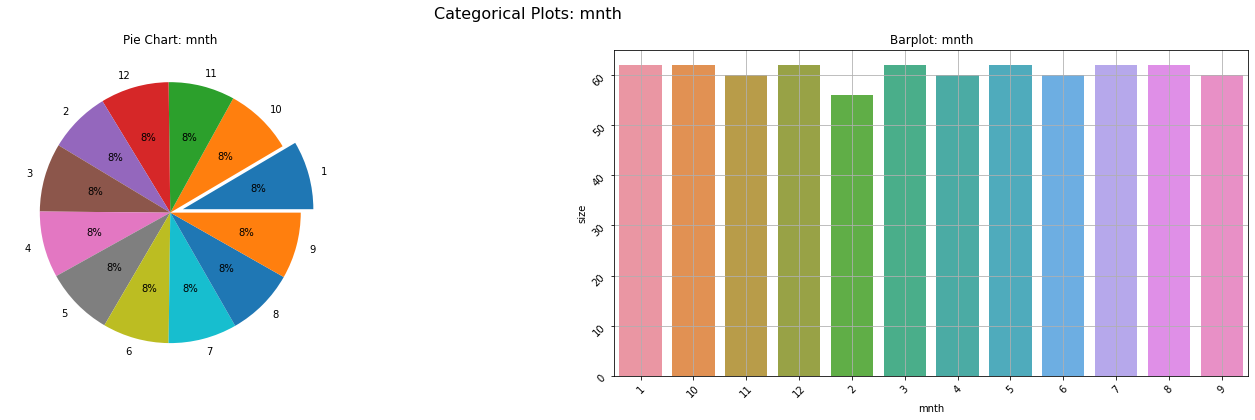

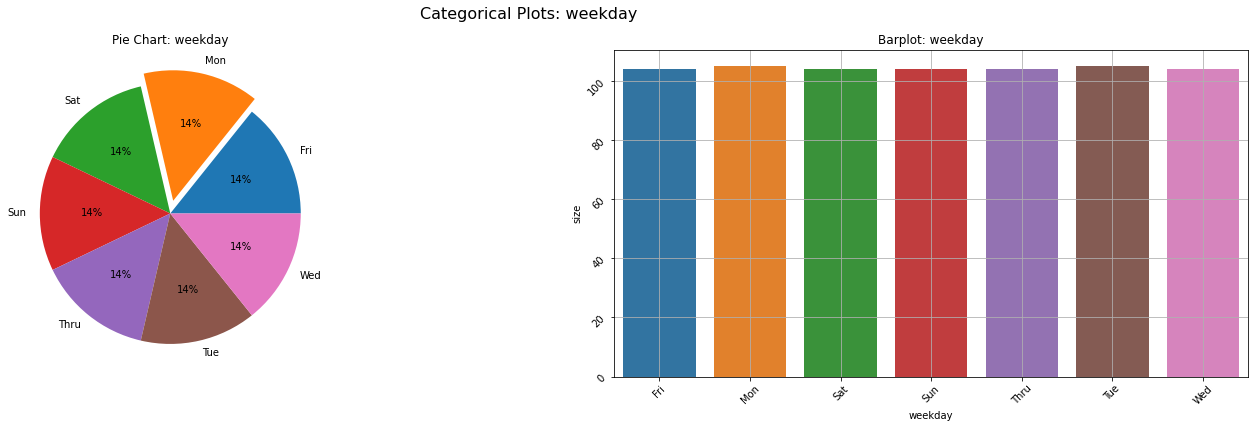

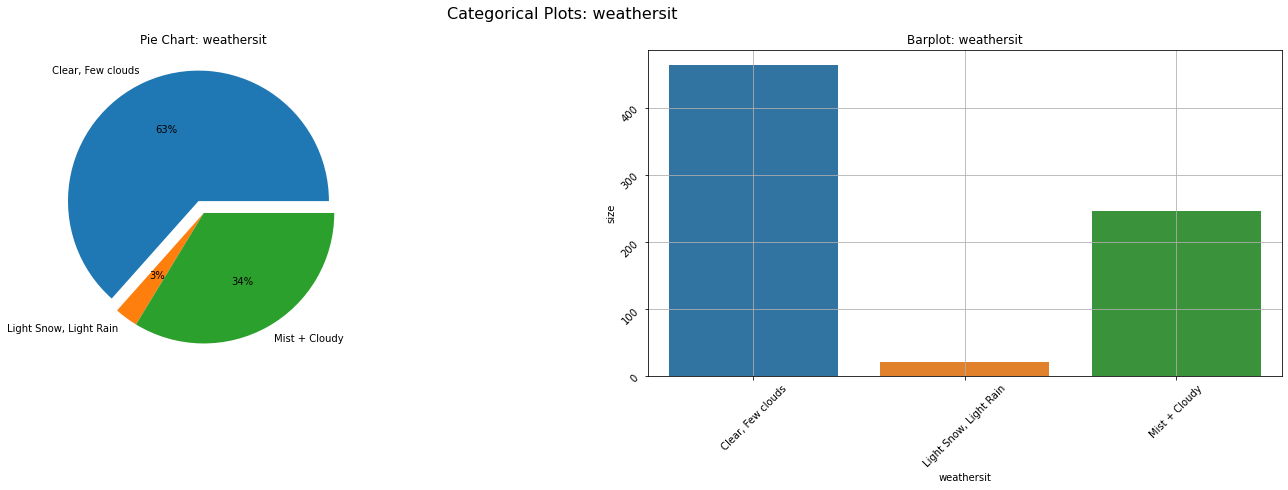

In [15]:
for column in df.columns.tolist():
    if is_object_dtype(df[column]):
        create_categorical_plots(df, column)

### Inference

- Uniform distribution of values in most of the columns
- Very less number of 'holidays' (~3%) and non working days (32%) [Intuitive as we have a continuous day level data]
- Weather situation = 3 {Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds} has a very slim presence in the dataset (only 3% of the total observations) 

In [16]:
df

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,2018-01-01,spring,0,1,0,Mon,0,Mist + Cloudy,18.18125,80.5833,10.749882,985
1,2018-01-02,spring,0,1,0,Tue,0,Mist + Cloudy,17.68695,69.6087,16.652113,801
2,2018-01-03,spring,0,1,0,Wed,1,"Clear, Few clouds",9.47025,43.7273,16.636703,1349
3,2018-01-04,spring,0,1,0,Thru,1,"Clear, Few clouds",10.60610,59.0435,10.739832,1562
4,2018-01-05,spring,0,1,0,Fri,1,"Clear, Few clouds",11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-27,spring,1,12,0,Fri,1,Mist + Cloudy,11.33210,65.2917,23.458911,2114
726,2019-12-28,spring,1,12,0,Sat,1,Mist + Cloudy,12.75230,59.0000,10.416557,3095
727,2019-12-29,spring,1,12,0,Sun,0,Mist + Cloudy,12.12000,75.2917,8.333661,1341
728,2019-12-30,spring,1,12,0,Mon,0,"Clear, Few clouds",11.58500,48.3333,23.500518,1796


In [17]:
#Defining the Object type columns for boxplot visualization

columns_for_boxplot = [x for x in df.columns if is_object_dtype(df[x])] + ['yr', 'holiday', 'workingday']
columns_for_boxplot

['season', 'mnth', 'weekday', 'weathersit', 'yr', 'holiday', 'workingday']

## Sid-by-side Boxplots

Text(0.5, 1.0, 'Boxplot: workingday')

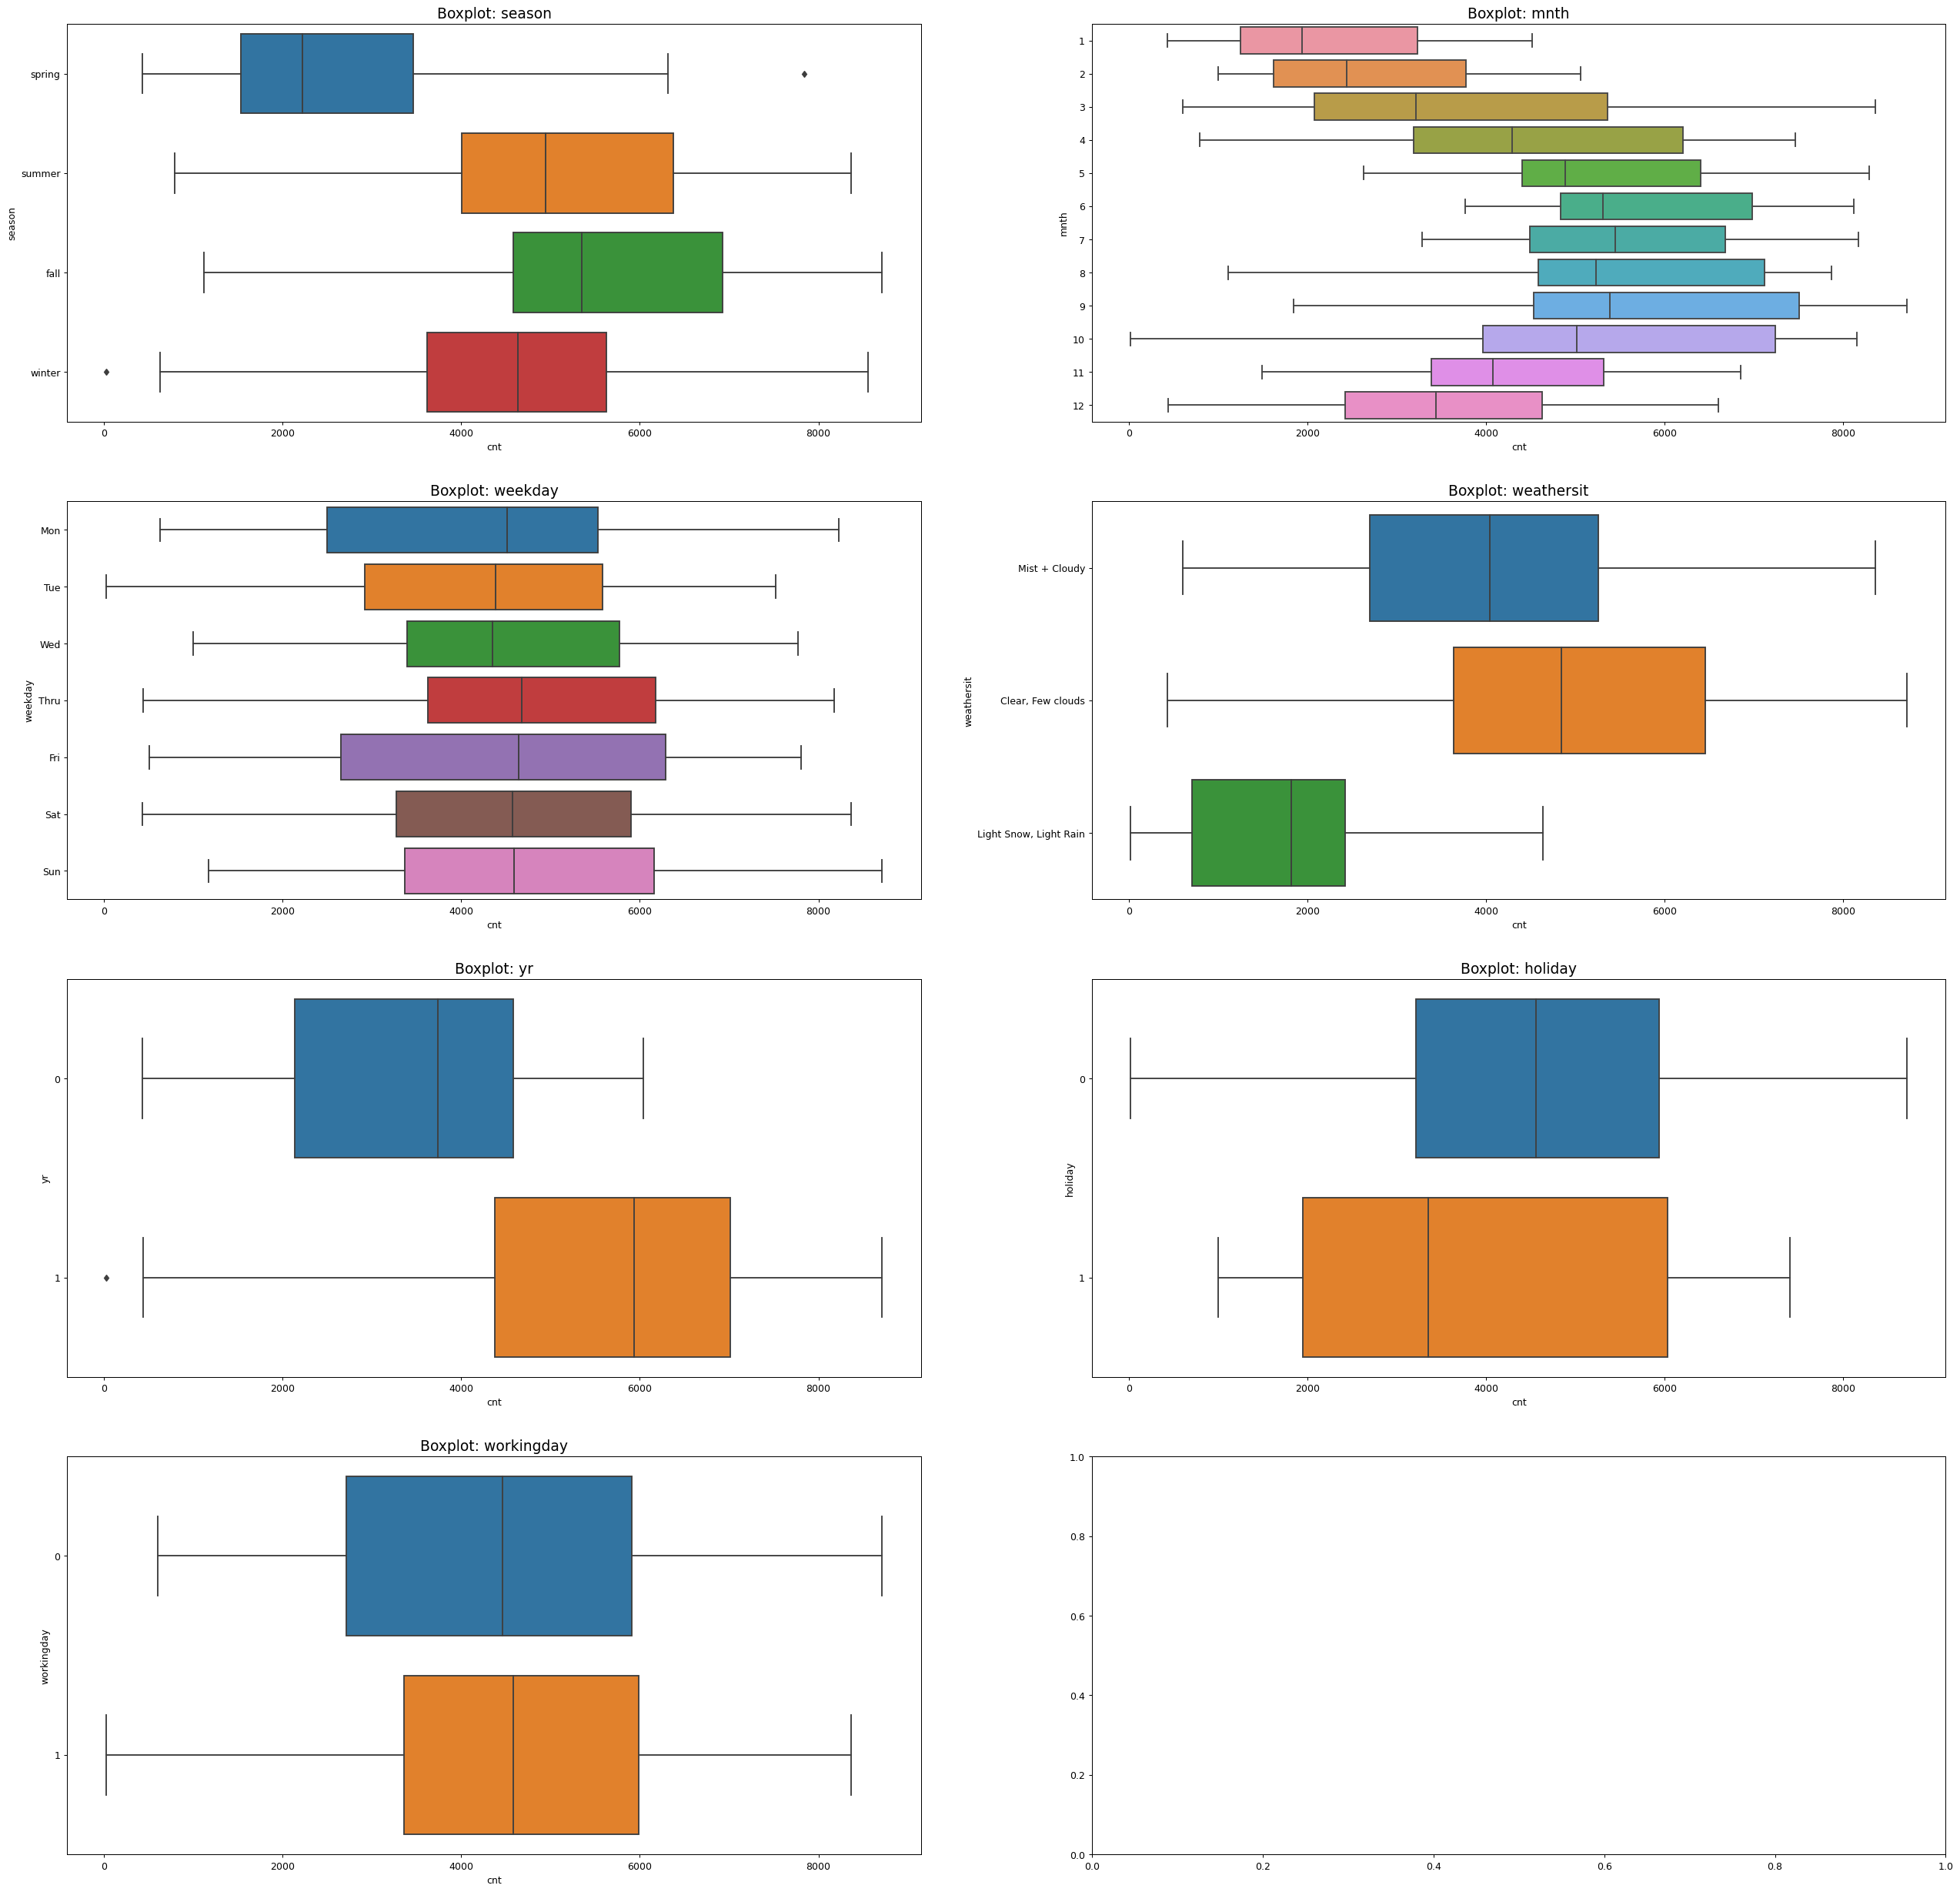

In [18]:
fig, ax = plt.subplots(4,2, figsize = (35, 35), dpi = 90)

sns.boxplot(data = df, x = 'cnt', y = columns_for_boxplot[0],ax = ax[0,0])
ax[0,0].set_title(f"Boxplot: {columns_for_boxplot[0]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = columns_for_boxplot[1],ax = ax[0,1])
ax[0,1].set_title(f"Boxplot: {columns_for_boxplot[1]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = columns_for_boxplot[2],ax = ax[1,0])
ax[1,0].set_title(f"Boxplot: {columns_for_boxplot[2]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = columns_for_boxplot[3],ax = ax[1,1])
ax[1,1].set_title(f"Boxplot: {columns_for_boxplot[3]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = df[columns_for_boxplot[4]].astype(str),ax = ax[2,0])
ax[2,0].set_title(f"Boxplot: {columns_for_boxplot[4]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = df[columns_for_boxplot[5]].astype(str),ax = ax[2,1])
ax[2,1].set_title(f"Boxplot: {columns_for_boxplot[5]}", fontsize = 15)

sns.boxplot(data = df, x = 'cnt', y = df[columns_for_boxplot[6]].astype(str),ax = ax[3,0])
ax[3,0].set_title(f"Boxplot: {columns_for_boxplot[6]}", fontsize = 15)


### Inference

- Spring season has the lowest demand, compared to other seasons
- On days with weather situation as light-snow, the demand has been the lowest
- Non- holidays contribute to more demand
- 2019 has comparatively more demand compared to 2018.


## Time Series Plot for Target Variable

<Figure size 1080x360 with 0 Axes>

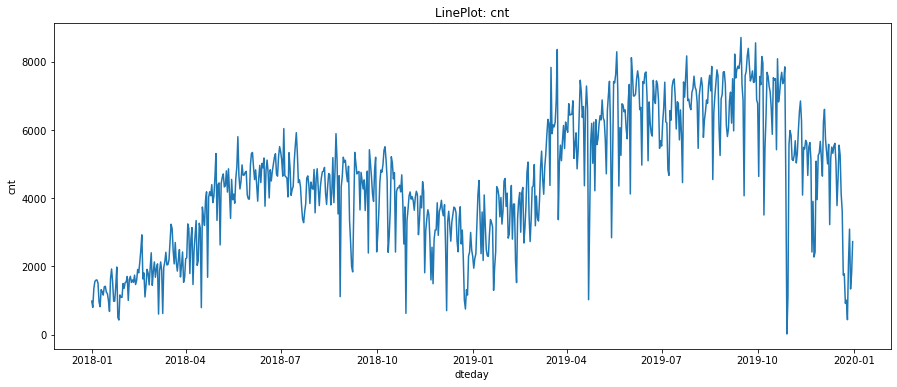

In [19]:
plt.figure(figsize = (15, 5))

plt.figure(figsize = (15, 6))
sns.lineplot(data = df, x = 'dteday', y = 'cnt')
plt.title("LinePlot: cnt")
plt.show()

### Inference

- Some seasons, quarters and months have high values compared to other time periods. This is again verified in the time series plot above, which shows the presence of a cyclic nature of the user count. {usually it is low around the start of the year and peaked around July-September} : This gives an idea that lagged or rolling values of 'cnt' can be used as predictors.


### Creating a New Feature which is the average demand of last 5 days (current day demand not included)

In [20]:
df['cnt_last5_days_mean'] = df['cnt'].rolling(window= 5).mean()
df['cnt_last5_days_mean'] = df['cnt_last5_days_mean'].shift(1)

### Handling Categorical Variables.

- Since all the categorical variables are nominal in nature, they can be simply one hot encoded
- We will not use 'drop_first = True' for all the columns, instead, for some columns, we will remove the OHE_column based on whichever level has the lowest percentage of records (to avoid having a sparse data)
    - e.g: column 'weathersit' has only 3% of observations, so if we use drop_first = True and remove 'weathersit = 1", which has 63% of the observations, we will be left with columns having only zeros for most of the records. So we can manually drop weathersit = 3.

In [21]:
drop_first_columns = ['season', 'mnth', 'weekday',]
manual_drop_cols = ['weathersit']

In [22]:
df_encoded1 = pd.get_dummies(df[drop_first_columns], drop_first = True)
df_encoded2 = pd.get_dummies(df[manual_drop_cols])
df_encoded2.head()

,"weathersit_ Clear, Few clouds","weathersit_Light Snow, Light Rain",weathersit_Mist + Cloudy
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,1,0,0


In [23]:
df_encoded2.drop(columns = [ 'weathersit_Light Snow, Light Rain'], inplace = True)

In [24]:
df_encoded = pd.concat([df, df_encoded1], axis = 'columns')
df_encoded = pd.concat([df_encoded, df_encoded2], axis = 'columns')

df_encoded.drop(columns = drop_first_columns+manual_drop_cols, inplace = True)

In [25]:
df_encoded.drop("dteday", axis = 1, inplace = True)

In [26]:
df_encoded = df_encoded.dropna(axis = 'rows')

***

## Train-Test Split

Divide the data into train and test data with 70-30 split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('cnt', axis = 1), df_encoded[['cnt']], test_size = 0.3, random_state = 42)

***

## Feature Scaling

Feature Scaling is needed for linear regression based algorithms, as without feature scaling, the model will have a bias towards the continuous variable with higher magnitude, and hence, the coefficient for that variable will be higher

In [28]:
scaler = StandardScaler()

features_to_scale = ['atemp', 'hum', 'windspeed','cnt_last5_days_mean']

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

## Feature Selection

In [29]:
def statmodel_lm(X_train,y_train):
    """Function For Creating a Multiple Linear Regression
    Model using the statsmodels library
    """
    X_train_lm = sm.add_constant(X_train)
    regressor = sm.OLS(y_train, X_train_lm).fit()
    return regressor

def calc_VIF(X_train):
    """Function for calculating the VIF value for each
    column in a dataframe
    """
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


### Create Linear Model With SKLearn and use Recursive Feature Elimination to filter out top 15 columns

In [30]:
model = LinearRegression()

model.fit(X_train, y_train)

rfe = RFE(model, 15)            
rfe = rfe.fit(X_train, y_train)

C:\Users\Debaratna\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [31]:
columns_to_filter = X_train.columns[rfe.support_]
columns_to_filter

Index(['yr', 'holiday', 'atemp', 'cnt_last5_days_mean', 'season_spring',
       'season_winter', 'mnth_11', 'mnth_12', 'mnth_3', 'mnth_5', 'mnth_9',
       'weekday_Mon', 'weekday_Tue', 'weathersit_ Clear, Few clouds',
       'weathersit_Mist + Cloudy'],
      dtype='object')

In [32]:
len(columns_to_filter)

15

## Filtering Out the Top 15 features for X_train and X_test

In [33]:
X_train = X_train[columns_to_filter]
X_test = X_test[columns_to_filter]

***

## Model Building

- Statsmodels OLS module used for modelling.
- VIF and P-value of Co-efficients will be used for filtering out columns in each iteration

# Logic
- Low p-value, low VIF : No need to drop

- High p-value, low VIF: drop first
- Low p-value, high VIF: drop next
- High p-value, high VIF: Drop

***

### Modelling Iteration-1

In [34]:
ols_model = statmodel_lm(X_train,y_train)
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     156.1
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          7.93e-176
Time:                        21:24:14   Log-Likelihood:                -4114.5
No. Observations:                 507   AIC:                             8261.
Df Residuals:                     491   BIC:                             8329.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          1718.8697    246.602      6.970      0.000    1234.343    2203.396
yr                             1328.2055    146.343      9.076      0.000    1040.670    1615.741
holiday                        -615.8659    206.326     -2.985      0.003   -1021.256    -210.475
atemp                           513.9716     72.377      7.101      0.000     371.764     656.179
cnt_last5_days_mean             584.7918    105.241      5.557      0.000     378.014     791.570
season_spring                  -694.2373    174.771     -3.972      0.000   -1037.628    -350.847
season_winter                   546.8828    127.689      4.283      0.000     295.999     797.766
mnth_11                        -516.0127    178.968     -2.883      0.004    -867.649    -164.376
mnth_12                        -440.7683    153.746     -2.867      0.004    -742.849    -138.687
mnth_3                          298.7529    172.684      1.730      0.084     -40.538     638.044
mnth_5                          318.5792    135.201      2.356      0.019      52.935     584.224
mnth_9                          463.2634    140.517      3.297      0.001     187.174     739.353
weekday_Mon                    -402.0573    110.309     -3.645      0.000    -618.793    -185.322
weekday_Tue                    -292.3111    105.371     -2.774      0.006    -499.345     -85.277
weathersit_ Clear, Few clouds  2663.1102    235.381     11.314      0.000    2200.632    3125.589
weathersit_Mist + Cloudy       1959.0685    238.015      8.231      0.000    1491.414    2426.723
==============================================================================
Omnibus:                      101.677   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.516
Skew:                          -0.967   Prob(JB):                     1.65e-62
Kurtosis:                       6.119   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Checking VIF For all columns

In [35]:
vif = calc_VIF(X_train)
vif

,Features,VIF
3,cnt_last5_days_mean,7.91
0,yr,7.87
4,season_spring,5.18
13,"weathersit_ Clear, Few clouds",4.79
2,atemp,3.76
14,weathersit_Mist + Cloudy,3.20
5,season_winter,2.89
6,mnth_11,1.84
7,mnth_12,1.40
9,mnth_5,1.26


### Observations

1. High p-value, high VIF: None
2. High p-value, low VIF: mnth_3
3. Low p-value, high VIF: cnt_last5_days_mean

**VERDICT**: Drop 'mnth_3' first as per logic

In [36]:
X_train2 = X_train.drop(columns = ['mnth_3'])


***

### Modelling Iteration 2

In [37]:
ols_model2 = statmodel_lm(X_train2,y_train)
ols_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     166.4
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          2.66e-176
Time:                        21:24:14   Log-Likelihood:                -4116.0
No. Observations:                 507   AIC:                             8262.
Df Residuals:                     492   BIC:                             8325.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          1721.8271    247.096      6.968      0.000    1236.334    2207.320
yr                             1313.0566    146.376      8.970      0.000    1025.457    1600.657
holiday                        -635.1506    206.441     -3.077      0.002   -1040.766    -229.535
atemp                           518.1082     72.484      7.148      0.000     375.692     660.525
cnt_last5_days_mean             597.2547    105.206      5.677      0.000     390.545     803.964
season_spring                  -630.5228    171.192     -3.683      0.000    -966.880    -294.165
season_winter                   542.4151    127.921      4.240      0.000     291.077     793.753
mnth_11                        -508.2281    179.273     -2.835      0.005    -860.463    -155.993
mnth_12                        -459.1033    153.691     -2.987      0.003    -761.074    -157.133
mnth_5                          305.4920    135.263      2.259      0.024      39.728     571.256
mnth_9                          445.9821    140.445      3.175      0.002     170.036     721.929
weekday_Mon                    -407.3966    110.489     -3.687      0.000    -624.485    -190.308
weekday_Tue                    -283.8884    105.472     -2.692      0.007    -491.119     -76.658
weathersit_ Clear, Few clouds  2669.4628    235.829     11.319      0.000    2206.107    3132.818
weathersit_Mist + Cloudy       1979.7997    238.194      8.312      0.000    1511.796    2447.804
==============================================================================
Omnibus:                       98.246   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.406
Skew:                          -0.923   Prob(JB):                     1.75e-62
Kurtosis:                       6.171   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking VIF Scores

In [38]:
vif2 = calc_VIF(X_train2)
vif2

,Features,VIF
3,cnt_last5_days_mean,7.87
0,yr,7.84
4,season_spring,4.95
12,"weathersit_ Clear, Few clouds",4.78
2,atemp,3.76
13,weathersit_Mist + Cloudy,3.16
5,season_winter,2.89
6,mnth_11,1.84
7,mnth_12,1.39
8,mnth_5,1.25


#### Since 'cnt_last5_days_mean' is an important derived feature, need to look at the correlation heatmap to see if the column has a 1-1 correlation with any other columns

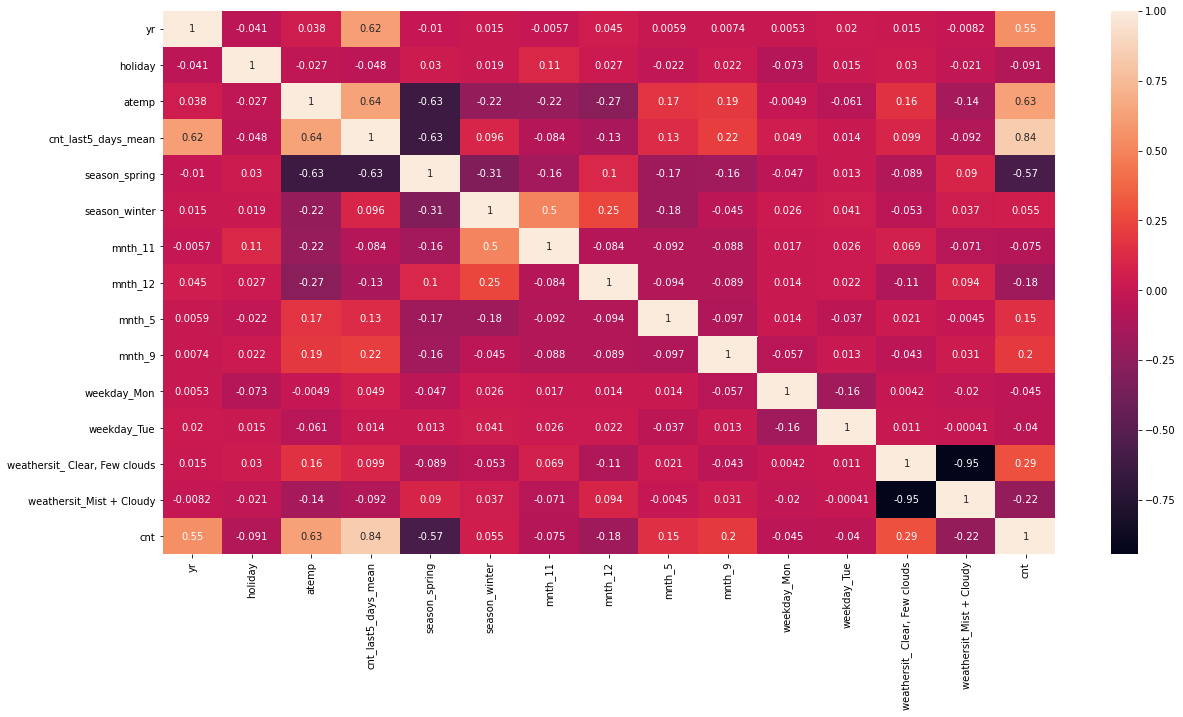

In [39]:
plt.figure(figsize = (20, 10))
sns.heatmap(pd.concat([X_train2, y_train], axis = 'columns').corr(),annot = True)
plt.show()

### CONCLUSION

Since **cnt_last5_days_mean** seems to have a high multicollinearity with **yr**, **atemp** and **season_spring** [although it has a correlatino of 0.84 with the target varialbe], I decided to drop the column owing to the fulfilling the assumptions of the Linear Regression Model. However, there are other regression models like tree-based models which handle multicollinearity pretty well. For those, removing the column won't be a necessity.

***

### Modelling Iteration 3

In [40]:
X_train3 = X_train2.drop(columns = ['cnt_last5_days_mean'])


In [41]:
ols_model3 = statmodel_lm(X_train3,y_train)
ols_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     166.2
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          1.12e-170
Time:                        21:24:17   Log-Likelihood:                -4132.1
No. Observations:                 507   AIC:                             8292.
Df Residuals:                     493   BIC:                             8351.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          1418.4584    248.771      5.702      0.000     929.676    1907.241
yr                             2031.1966     75.942     26.747      0.000    1881.986    2180.407
holiday                        -597.4162    212.769     -2.808      0.005   -1015.462    -179.371
atemp                           740.3006     62.911     11.767      0.000     616.693     863.908
season_spring                 -1111.2669    153.420     -7.243      0.000   -1412.704    -809.830
season_winter                   746.8473    126.575      5.900      0.000     498.153     995.541
mnth_11                        -794.1603    177.418     -4.476      0.000   -1142.748    -445.572
mnth_12                        -599.0598    156.431     -3.830      0.000    -906.414    -291.706
mnth_5                          352.4824    139.219      2.532      0.012      78.946     626.019
mnth_9                          613.4534    141.594      4.332      0.000     335.251     891.656
weekday_Mon                    -335.0778    113.175     -2.961      0.003    -557.442    -112.714
weekday_Tue                    -226.3984    108.258     -2.091      0.037    -439.103     -13.694
weathersit_ Clear, Few clouds  2655.5896    243.170     10.921      0.000    2177.812    3133.367
weathersit_Mist + Cloudy       1949.7093    245.562      7.940      0.000    1467.233    2432.186
==============================================================================
Omnibus:                       71.381   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.265
Skew:                          -0.688   Prob(JB):                     2.41e-43
Kurtosis:                       5.720   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Checking VIF Scores

In [42]:
vif3 = calc_VIF(X_train3)
vif3

,Features,VIF
11,"weathersit_ Clear, Few clouds",3.62
3,season_spring,3.61
2,atemp,2.75
4,season_winter,2.72
12,weathersit_Mist + Cloudy,2.45
0,yr,2.08
5,mnth_11,1.70
6,mnth_12,1.35
7,mnth_5,1.25
10,weekday_Tue,1.21


***

## CONCLUSION

Finally, left with 13 features which satisfy the pre-conditions for a Multiple Linear Regression Model

In [43]:
final_columns = X_train3.columns

***
***

## FINAL MODEL

In [44]:
model = LinearRegression()
model.fit(X_train3, y_train)

LinearRegression()

## RESIDUAL ANALYSIS

### Three Checks:

1. Error Terms Normally Distributed
2. Error Terms are independent of each other
3. Homoscedasticity of Error

### 1. Check if Error Terms are Normally Distributed

In [45]:
error_terms = y_train.values-model.predict(X_train3)

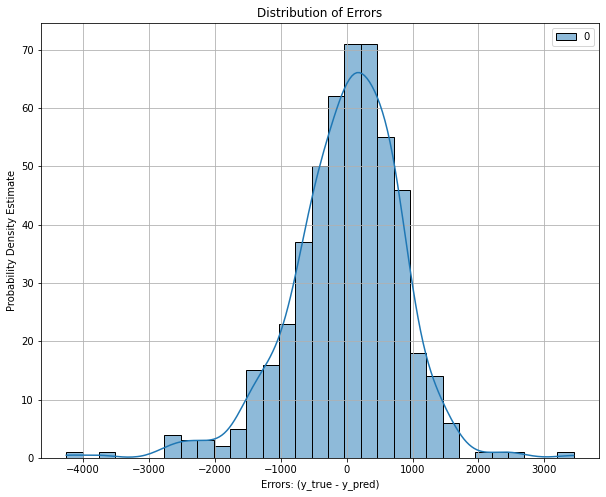

In [46]:
plt.figure(figsize = (10, 8))
sns.histplot(error_terms,kde = True)
plt.title('Distribution of Errors')
plt.xlabel('Errors: (y_true - y_pred)')
plt.ylabel("Probability Density Estimate")
plt.grid()

## Observations

- The Errors seem to be normally distributed with mean around zero

***

## 2. Check For Independence of Errors

- Use Durbin-Watson Test to Check for serial autocorrelation in residuals

In [47]:
from statsmodels.stats.stattools import durbin_watson

In [48]:
print(f"Durbin-Watson Statistic: {durbin_watson(error_terms)[0]}")

Durbin-Watson Statistic: 1.933597683754885


### CONCLUSION

- The statistic of 1.933 is almost close to 2, which signifies no serial correlation in the residuals

***

## 3. Checking For Homoscedasticity of Errors

- Plot the scatterplot of Residuals and see if it is evenly distributed around the horizontal line passing through zero

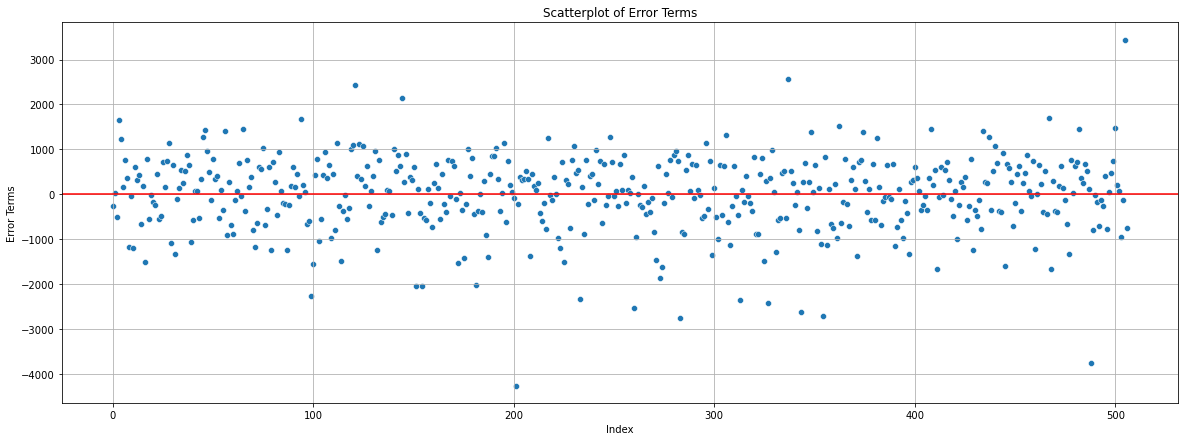

In [49]:
plt.figure(figsize = (20, 7))

sns.scatterplot(x = X_train.reset_index().index.values.tolist(), y = error_terms.flatten())
plt.axhline(color = 'red')
plt.grid()

plt.title("Scatterplot of Error Terms")
plt.xlabel("Index")
plt.ylabel("Error Terms")
plt.show()

## CONCLUSION

- The Error Terms Seem to be almost Evenly distributed around the horizontal line passing through 0

***

## MODEL INFERENCE

In [50]:
#Generating predictions on the test data

y_pred = model.predict(X_test[final_columns])

## Validating the Linearity Assumption Of the Multiple Linear Regression Model

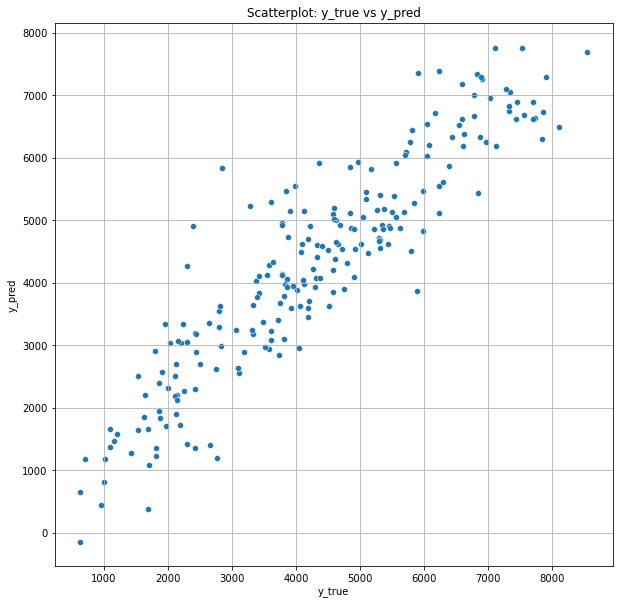

In [51]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = y_test['cnt'], y = y_pred.flatten())
plt.grid()
plt.title("Scatterplot: y_true vs y_pred")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.show()

### Inference

- The linear relationship seems to be valid as the y_true to y_pred scatterplot shows a linear relationship.

***

## Model Evaluation

As per the requirement of the assignment, the model is evaluated based on the R2 Score.

In [52]:
#r2 score

r2_score(y_test, y_pred)

0.8384535700334502

## INFERENCE

**The R2 Score on The Test Set is ~0.84**

***

## Feature Importance Plot

Text(0, 0.5, 'Features')

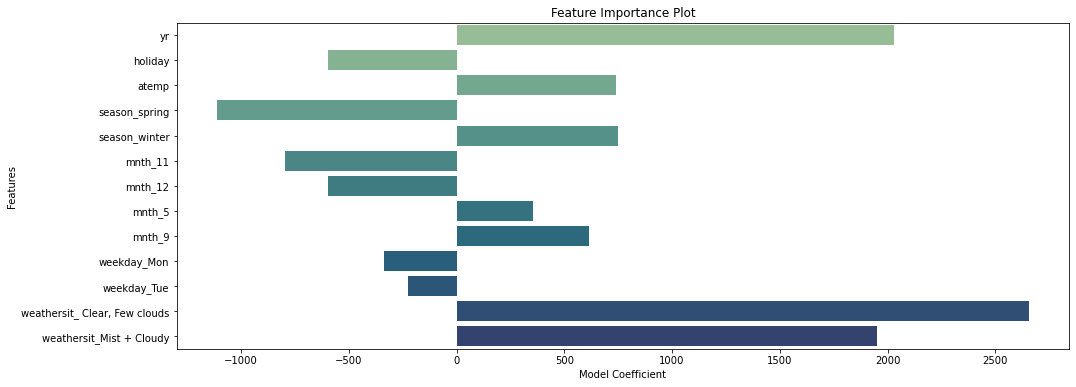

In [53]:
plt.figure(figsize = (16,6))
sns.barplot(x = model.coef_[0],
           y = final_columns, 
           palette = 'crest')
plt.title("Feature Importance Plot")
plt.xlabel("Model Coefficient")
plt.ylabel("Features")

## FINAL IMPRESSIONS ON THE MODEL

- There is a positive weightage on the weather situation; If the weather is clear/misty then the demand will be higher compared to rainy weather situation.
- The year seems to have a high value of coefficient; as there has been a visible increase in Year-On-Year demand.
- Spring season has a high negative value of coefficient, while winter has a moderately high positive value
- holiday has a negative coefficient, indicating that keeping all other variables constant, the demand will be higher on non-holiday calendar dates, which is also evident from the box plot.
- The first two starting days of the week, i.e monday and tuesday show a negative coefficient, which is also evident from the boxplot representation that the demand is comparatively lower on monday and tuesday.